In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !mkdir /content/gdrive/MyDrive/facial-key-points-detection/data‬‏
# !wget -P /content/gdrive/MyDrive/facial-key-points-detection/data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip

In [3]:
# !unzip -n  /content/gdrive/MyDrive/facial-key-points-detection/data/train-test-data.zip -d  /content/gdrive/MyDrive/facial-key-points-detection/data/

In [4]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2
from numpy.ma.core import resize

In [5]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


In [6]:
key_pts_frame = pd.read_csv('/content/gdrive/MyDrive/facial-key-points-detection/data/test_frames_keypoints.csv')
key_pts_frame.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,...,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,...,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0


In [7]:
key_pts_frame = pd.read_csv('/content/gdrive/MyDrive/facial-key-points-detection/data/test_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))
print('Number of images: ', key_pts_frame.shape[0])

Image name:  James_Wolfensohn_00.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[25. 44.]
 [25. 49.]
 [25. 54.]
 [25. 59.]]
Number of images:  770


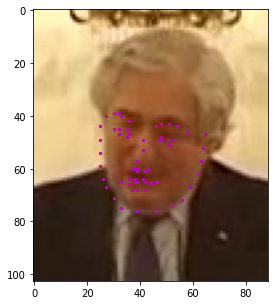

In [8]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/content/gdrive/MyDrive/facial-key-points-detection/data//training/', image_name)), key_pts)
plt.show()

In [9]:
the_img_new_hight_and_width = 175

In [10]:
def scale_and_normalize(image, key_ptss):
        image_copy = np.copy(image)
        key_pts = key_ptss.copy()

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        h, w = image_copy.shape

        img = image_copy
        # img = img.resize()
        img = cv2.resize(img,(the_img_new_hight_and_width, the_img_new_hight_and_width))

        
        # scale the pts, too
        key_pts = key_pts * [the_img_new_hight_and_width / w, the_img_new_hight_and_width / h]

        return img, key_pts

def random_crops(imagee, key_ptss):
        image = imagee.copy()
        key_pts = key_ptss.copy()
        h, w = image.shape
        new_h = 75
        new_w = 75

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        for i in range(len(key_pts)):
          key_pts[i][0] = key_pts[i][0]-left
          key_pts[i][1] = key_pts[i][1]-top

        h, w = image.shape
        image = cv2.resize(image,(the_img_new_hight_and_width, the_img_new_hight_and_width))

        key_pts = key_pts * [the_img_new_hight_and_width / w, the_img_new_hight_and_width / h]


        return image, key_pts

def random_padding(imagee, key_ptss, top=250, bottom=250, left=250, right=250):
        image = imagee.copy()
        key_pts = key_ptss.copy()

        top_padding = np.random.randint(0, top)
        bottom_padding = np.random.randint(0, bottom)

        left_padding = np.random.randint(0, left)
        right_padding = np.random.randint(0, right)

        value = np.random.random_sample()

        image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, None, value)

        for i in range(len(key_pts)):
          key_pts[i][0] = key_pts[i][0] + (left_padding)
          key_pts[i][1] = key_pts[i][1] + (top_padding)

        h, w = image.shape
        image = cv2.resize(image,(the_img_new_hight_and_width, the_img_new_hight_and_width))

        key_pts = key_pts * [the_img_new_hight_and_width / w, the_img_new_hight_and_width / h]



        return image, key_pts



def get_slimmer_faces(imagee, key_ptss, top=0, bottom=0, left=250, right=250):
        image = imagee.copy()
        key_pts = key_ptss.copy()

        value = np.random.random_sample()

        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, None, value)

        for i in range(len(key_pts)):
          key_pts[i][0] = key_pts[i][0] + (left)
          key_pts[i][1] = key_pts[i][1] + (top)

        h, w = image.shape
        image = cv2.resize(image,(the_img_new_hight_and_width, the_img_new_hight_and_width))

        key_pts = key_pts * [the_img_new_hight_and_width / w, the_img_new_hight_and_width / h]

        # image, key_pts = random_padding(image, key_pts, 50,50,50,50)

        return image, key_pts


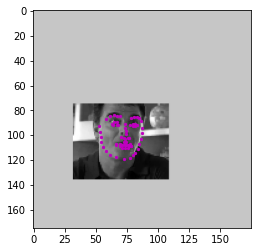

In [11]:
image_namee = key_pts_frame.iloc[200][0]
orgimage, orgkey_pts = scale_and_normalize( mpimg.imread('/content/gdrive/MyDrive/facial-key-points-detection/data/training/'+image_namee), 
                              key_pts_frame.iloc[200][1:].astype('float').to_numpy().reshape(-1,2))


image, key_pts = random_padding( orgimage, orgkey_pts)

show_keypoints(image, key_pts)

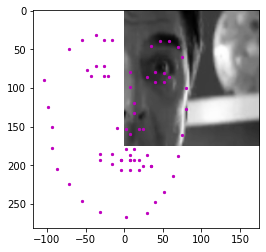

In [12]:
image, key_pts = random_crops( orgimage, orgkey_pts)
show_keypoints(image, key_pts)

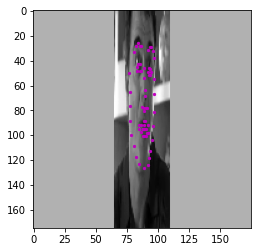

In [13]:
image, key_pts = get_slimmer_faces( orgimage, orgkey_pts)
show_keypoints(image, key_pts)

In [14]:
def load_testing_data(csv_path):
  key_pts_frame = pd.read_csv(csv_path)
  y = []
  X = []
  for i in tqdm(range(len(key_pts_frame))):
    image_name = key_pts_frame.iloc[i, 0]
    key_pointss = key_pts_frame.iloc[i][1:].astype('float').to_numpy().reshape(-1,2)
    immgg , keyy = scale_and_normalize(mpimg.imread(os.path.join('/content/gdrive/MyDrive/facial-key-points-detection/data/test/', image_name)), 
                                       key_pointss)
    
    y.append(keyy.astype('float').reshape(-1))
    X.append(immgg)

  y = np.array(y)
  X = np.array(X)
  return X,y

In [15]:
def load_augmented_training_data(csv_path):

  key_pts_frame = pd.read_csv(csv_path)
  y = []
  X = []
  for i in tqdm(range(len(key_pts_frame))):
    image_name = key_pts_frame.iloc[i, 0]
    key_pointss = key_pts_frame.iloc[i][1:].astype('float').to_numpy().reshape(-1,2)
    imagee = mpimg.imread(os.path.join('/content/gdrive/MyDrive/facial-key-points-detection/data/training/', image_name))

    org_immgg , org_keyy = scale_and_normalize(imagee, key_pointss)
    y.append(org_keyy.astype('float').reshape(-1))
    X.append(org_immgg)

    # just for random paddings
    immgg , keyy = random_padding(org_immgg, org_keyy)
    y.append(keyy.astype('float').reshape(-1))
    X.append(immgg)

    # just for random paddings with slimmer faces for 50%
    if i %2 == 0:
      immgg , keyy = get_slimmer_faces(org_immgg, org_keyy)
      y.append(keyy.astype('float').reshape(-1))
      X.append(immgg)

    # randomly croped
    immgg , keyy = random_crops(org_immgg, org_keyy)
    y.append(keyy.astype('float').reshape(-1))
    X.append(immgg)

    # croped with random paddings for 50%
    if i %2 == 0:
      immgg , keyy = random_padding(immgg, keyy)
      y.append(keyy.astype('float').reshape(-1))
      X.append(immgg)

  y = np.array(y)
  X = np.array(X)
  return X,y


In [16]:
X_test, y_test = load_testing_data('/content/gdrive/MyDrive/facial-key-points-detection/data/test_frames_keypoints.csv')
X_train, y_train = load_augmented_training_data('/content/gdrive/MyDrive/facial-key-points-detection/data/training_frames_keypoints.csv')

100%|██████████| 3462/3462 [00:44<00:00, 77.09it/s]


In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13848, 175, 175) (13848, 136)
(770, 175, 175) (770, 136)


# Scale the point to be from 0 to 1 instead from 0 to 175

In [18]:
y_train = y_train/the_img_new_hight_and_width
y_test = y_test/the_img_new_hight_and_width

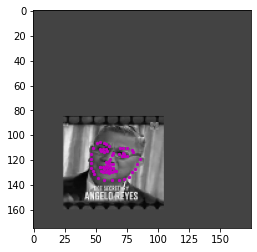

In [19]:
show_keypoints(X_train[14], y_train[14].reshape(-1,2) *the_img_new_hight_and_width)

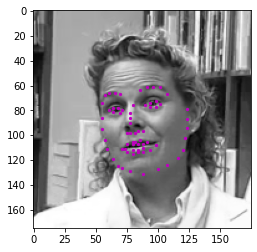

In [20]:
show_keypoints(X_train[16], y_train[16].reshape(-1,2) *the_img_new_hight_and_width)

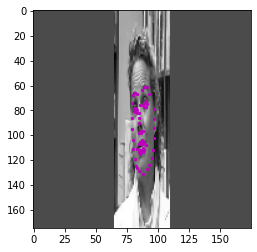

In [21]:
show_keypoints(X_train[18], y_train[18].reshape(-1,2) *the_img_new_hight_and_width)

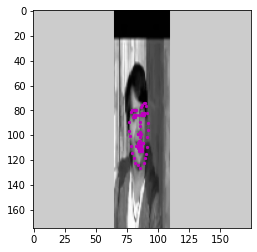

In [22]:
show_keypoints(X_train[2], y_train[2].reshape(-1,2) *the_img_new_hight_and_width)

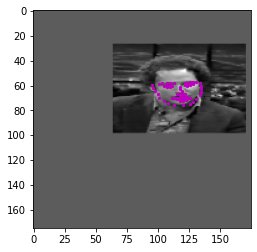

In [23]:
show_keypoints(X_train[22], y_train[22].reshape(-1,2) *the_img_new_hight_and_width)

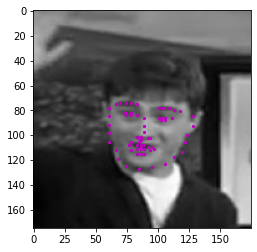

In [24]:
show_keypoints(X_train[24], y_train[24].reshape(-1,2) *the_img_new_hight_and_width)

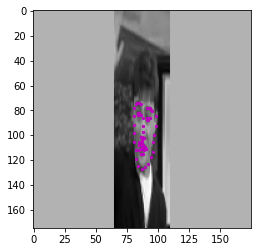

In [25]:
show_keypoints(X_train[26], y_train[26].reshape(-1,2) *the_img_new_hight_and_width)

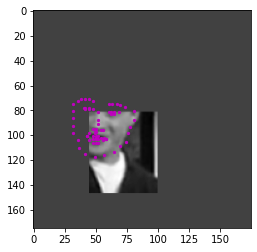

In [26]:
show_keypoints(X_train[28], y_train[28].reshape(-1,2) *the_img_new_hight_and_width)

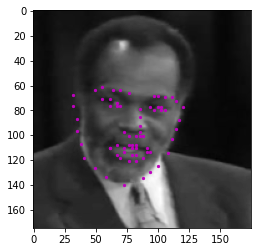

In [27]:
show_keypoints(X_test[22], (y_test[22]*the_img_new_hight_and_width).reshape(-1,2))

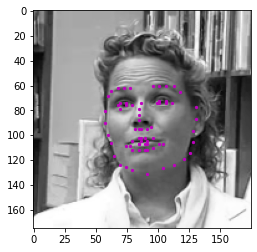

In [28]:
show_keypoints(X_test[2], (y_test[2]*the_img_new_hight_and_width).reshape(-1,2))

In [29]:
np.save('/content/gdrive/MyDrive/facial-key-points-detection/data/X_train.npy',X_train)
np.save('/content/gdrive/MyDrive/facial-key-points-detection/data/y_train.npy',y_train)

np.save('/content/gdrive/MyDrive/facial-key-points-detection/data/X_test.npy',X_test)
np.save('/content/gdrive/MyDrive/facial-key-points-detection/data/y_test.npy',y_test)